In [1]:
#Import packages
import os
import glob
import json
import random

#from tqdm import tqdm

import nilearn
import nibabel as nib
from nilearn import image as nimg
from nilearn import plotting as nplot
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix, run_glm
from nilearn.glm import fdr_threshold,threshold_stats_img
from nilearn.glm.contrasts import compute_contrast


from bids.layout import BIDSLayout, parse_file_entities

# import cortex
# from cortex import fmriprep

from nipype.interfaces.workbench.base import WBCommand
from nipype.algorithms import modelgen
from nipype.interfaces.base import Bunch

import scipy.stats as stats

import hcp_utils as hcp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#! module load openmind/hcp-workbench/1.2.3

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [14]:
roi = np.loadtxt('pataka_froi.csv')
sub_level_effect_size_df = pd.read_pickle('ACOMPCOR_sub_level_effect_size_df.pkl')

In [4]:
train = sub_level_effect_size_df[[c for c in sub_level_effect_size_df.columns if 'run-1' in c]]
test = sub_level_effect_size_df[[c for c in sub_level_effect_size_df.columns if 'run-1' not in c]]
task = 'pataka'
train_sample = train[[c for c in train.columns if task in c]]
test_sample = test[[c for c in test.columns if task in c]]

In [7]:
np.unique(roi, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 array([88495,   774,    59,   103,   415,    16,    40,    23,   728,
           44,   553,    32]))

In [15]:
np.unique(roi, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 array([88495,   774,    59,   103,   415,    16,    40,    23,   728,
           44,   553,    32]))

In [8]:
# roi_to_exclude = [4,5,6,10,11]
# roi_new = []
# for r in roi:
#     if r in roi_to_exclude:
#         r = 0
#         roi_new.append(r)
#     else:
#         roi_new.append(r)
# roi = np.array(roi_new)

In [16]:
test_zscore = test_sample.apply(stats.zscore, axis =0) #z-score betas
fdr = test_zscore.apply(lambda z: fdr_threshold(z, alpha=0.05)) #calculate per-run fdr threshold

cluster_ids = np.unique(roi)
cluster_ids = cluster_ids[cluster_ids>0]

parcel_fx={}
run_means={}
#go through each parcel, look at voxels in it
#only analyze the parcel if >10% of voxels in the parcel are significant, with FDR of 0.5 per run

for cid in cluster_ids:
    #mask by each parcel
    mask = np.where(roi==cid, 1, 0)
    
    # keep only greyordinates in a parcel. 
    # Use EFFECT SIZE not z-score
    #greyord_in_parcel = test_zscore.multiply(mask, axis=0)
    z_greyord_in_parcel = test_sample.multiply(mask, axis=0)

    
    #threshold 
    
    sig_gord_in_parcel = []
    # for c in z_greyord_in_parcel.columns:
    #     sig_idx = np.concatenate((np.where(z_greyord_in_parcel[c] > fdr[c])[0], np.where(z_greyord_in_parcel[c] < -fdr[c])[0]))
    #     if sig_idx.shape[0]/np.sum(mask) > 0.1:
    #         sig_gord_in_parcel.append(test_sample[c][sig_idx].to_numpy())    
    # parcel_fx[cid] = np.concatenate(sig_gord_in_parcel)
    # run_means[cid] = [np.mean(sg) for sg in sig_gord_in_parcel]
    
    col_means = []
    for c in z_greyord_in_parcel.columns:
        sig_idx = np.where(z_greyord_in_parcel[c] > fdr[c], 1, 0) + np.where(z_greyord_in_parcel[c] < -fdr[c], 1, 0)
        if sig_idx.sum()/np.sum(mask) > 0.1:
            sig_mask = test_sample[c]*sig_idx
            sig_gord_in_parcel.append(sig_mask)
            col_means.append(sig_mask.mean())
        else:
            col_means.append(np.nan)
    parcel_fx[cid] = test_sample[c].iloc[np.where(sig_mask != 0)].to_numpy()
    run_means[cid] = col_means
    
fx = pd.concat([pd.DataFrame(fx, columns=[p]) for p, fx in parcel_fx.items()], axis=1)
run_means = pd.DataFrame(run_means, index=test_sample.columns)

In [17]:
run_means.to_pickle('ACOMPCOP_run_means.pkl')

In [18]:
fx.to_pickle('ACOMPCOP_fx.pkl')

In [19]:
test_sample

,sub-voice884_ses-1_task-pataka_run-2,sub-voice953_ses-1_task-pataka_run-2,sub-voice976_ses-1_task-pataka_run-2,sub-voice895_ses-1_task-pataka_run-2,sub-voice875_ses-1_task-pataka_run-2,sub-voice875_ses-2_task-pataka_run-2,sub-voice956_ses-1_task-pataka_run-2,sub-voice956_ses-2_task-pataka_run-2,sub-voice962_ses-1_task-pataka_run-2,sub-voice967_ses-1_task-pataka_run-2,...,sub-voice873_ses-1_task-pataka_run-2,sub-voice886_ses-1_task-pataka_run-2,sub-voice960_ses-1_task-pataka_run-2,sub-voice958_ses-1_task-pataka_run-2,sub-voice969_ses-1_task-pataka_run-2,sub-voice951_ses-1_task-pataka_run-2,sub-voice862_ses-1_task-pataka_run-2,sub-voice955_ses-1_task-pataka_run-2,sub-voice854_ses-1_task-pataka_run-2,sub-voice872_ses-1_task-pataka_run-2
0,-2.186558,0.406931,-4.600022,-1.460227,0.178190,0.199900,1.435901,-1.787035,-0.196703,-2.004479,...,-0.928525,-1.763391,-0.051603,-0.415023,-4.002977,-2.933944,-0.236511,0.362625,-3.485118,-1.932069
1,0.641032,0.761496,-1.960246,1.276959,0.001553,0.913093,-1.111243,-1.189838,-0.120967,0.304247,...,-0.779034,-2.593152,1.982865,0.887263,-2.323847,-2.484384,0.577363,-0.450338,-2.679658,-2.910948
2,15.451931,-2.606383,20.354482,19.552946,11.819086,14.421224,4.603186,10.002553,17.592289,18.780608,...,24.286509,21.508924,20.610435,15.412515,7.697094,5.883706,9.406752,10.865557,27.645212,12.506598
3,0.463039,0.950729,-0.289032,-0.750777,4.590188,4.880045,0.052960,-0.387040,-2.001778,5.106376,...,4.862570,4.294280,1.845894,0.251785,0.874267,2.915248,1.702307,0.888005,1.742883,-3.002082
4,0.655142,1.685574,-4.652430,2.954140,1.159720,5.203560,-0.497285,-1.334586,6.882682,1.240607,...,-1.259365,-5.956073,-4.752956,1.871993,-6.350418,-0.087323,-1.284020,3.141973,4.253023,-1.269115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91277,2.264019,-0.244702,-1.968934,5.263077,-1.920339,2.111702,-2.373657,-1.041305,3.502745,4.816357,...,1.414249,4.735410,2.991553,1.847241,0.689548,0.118778,1.278378,-0.500196,0.832092,-0.292222
91278,2.917496,2.632811,-3.350637,4.466546,-2.782460,0.498463,1.074910,-1.944815,-1.240940,-3.068729,...,0.224392,1.344562,1.099550,1.908857,2.343403,0.494373,-0.358530,-0.682234,0.826499,-0.481148
91279,3.035722,1.561669,-3.301052,5.739975,-3.161432,1.921309,-0.144124,-2.143339,0.005698,-0.667112,...,0.423873,2.403748,1.616023,0.444446,1.402453,0.024121,0.250048,-1.027837,1.021920,0.090429
91280,2.329311,0.184212,-2.219309,5.140399,-2.946785,2.957294,-1.655133,-1.321572,2.013004,3.002017,...,1.149427,3.960393,2.656983,0.737398,0.890349,0.252372,1.083739,-0.586299,0.696446,-0.249567


In [66]:
diagnosis = []
for idx in train_sample.columns:
    if int(idx.split('voice')[1].split('_ses')[0]) > 900:
        diagnosis.append('mdd')
    else:
        diagnosis.append('control')
#run_means['diagnosis'] = diagnosis 

In [67]:
mdd = train_sample.iloc[:,[d=='mdd' for d in diagnosis]]
control = train_sample.iloc[:,[d=='control' for d in diagnosis]]

In [65]:


# k = number of items to select
#sample_list = random.choices(original_list, k=3)

In [68]:
mdd_sub = list(mdd.columns)
control_sub = list(control.columns)

In [69]:
sample_mdd = random.choices(mdd_sub, k=3)
sample_control = random.choices(control_sub, k=3)

In [70]:
control[sample_control]

,sub-voice889_ses-1_task-pataka_run-1,sub-voice891_ses-1_task-pataka_run-1,sub-voice850_ses-1_task-pataka_run-1
0,-0.189063,-4.647705,0.968644
1,-0.489365,-0.537425,0.546336
2,8.933285,17.755546,6.073989
3,0.160268,0.275218,1.754262
4,-1.406686,-9.519411,2.221330
...,...,...,...
91277,0.321449,0.784081,2.110848
91278,1.804082,-0.417779,1.474091
91279,0.112165,-0.166529,1.256092
91280,0.388032,0.891636,1.587707


In [73]:
sample_control

['sub-voice889_ses-1_task-pataka_run-1',
 'sub-voice891_ses-1_task-pataka_run-1',
 'sub-voice850_ses-1_task-pataka_run-1']

In [74]:
sample_mdd

['sub-voice978_ses-1_task-pataka_run-1',
 'sub-voice952_ses-1_task-pataka_run-1',
 'sub-voice958_ses-1_task-pataka_run-1']

In [77]:
bdi_scores = pd.read_csv('bdi_scores.csv', index_col=0)[['voice_id','age','sex','beckdepressionii_total']]

In [82]:
bdi_scores[[bs in [889,891,850,978,952,958] for bs in bdi_scores.voice_id]]

,voice_id,age,sex,beckdepressionii_total
19,891,25.0,1.0,24.0
21,889,62.0,1.0,20.0
64,978,51.0,1.0,4.0
92,850,28.0,0.0,21.0
106,958,23.0,1.0,0.0
118,952,22.0,0.0,1.0


In [93]:
for a, v in bdi_scores.groupby('sex'):
    print(v[v.beckdepressionii_total<14].shape)

(13, 4)
(19, 4)


In [96]:
bdi_scores[bdi_scores.beckdepressionii_total<14].shape

(32, 4)

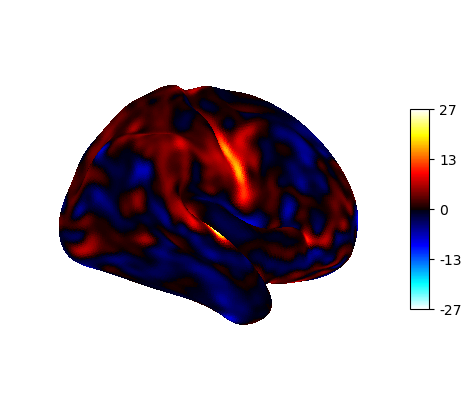

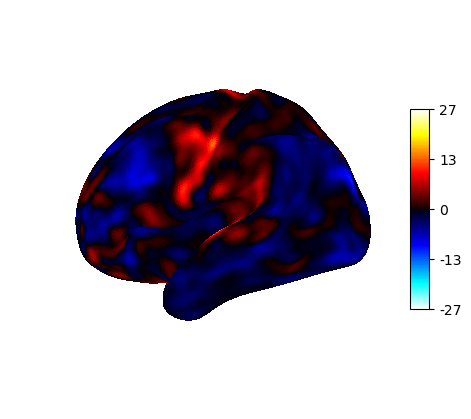

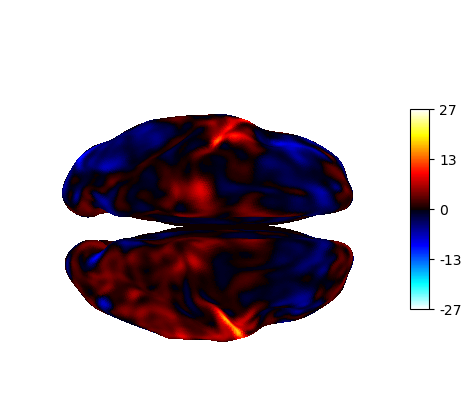

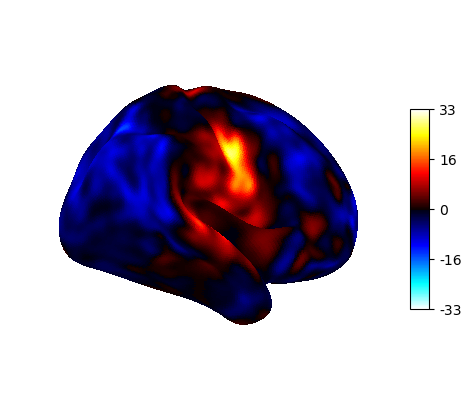

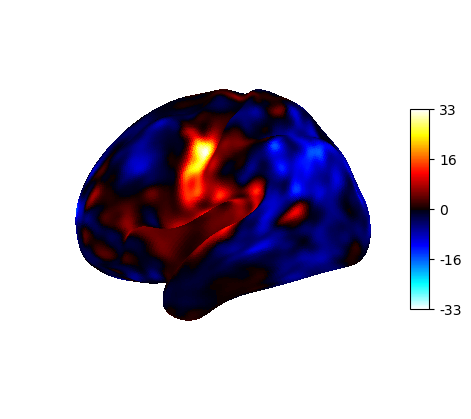

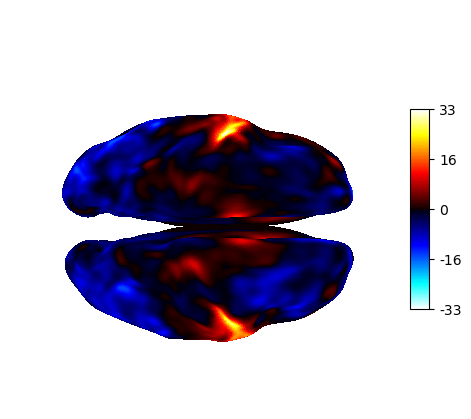

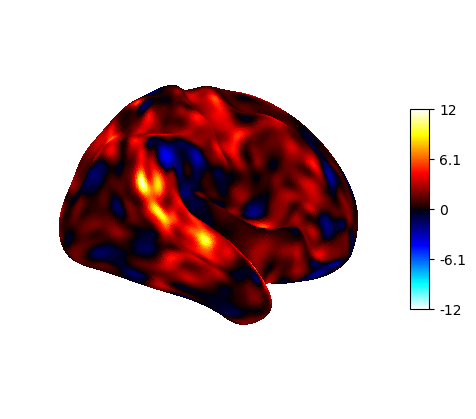

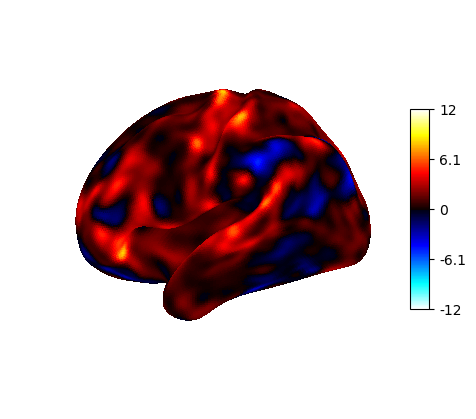

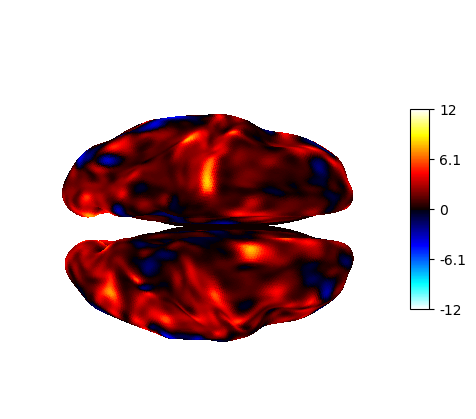

In [71]:
for sc in sample_control:
    nplot.plot_surf_stat_map(
            hcp.mesh.inflated, hcp.cortex_data(control[sc].to_numpy()), hemi='right',# threshold=fdr[sc],
            colorbar=True,
            bg_map=hcp.mesh.sulc)

    nplot.plot_surf_stat_map(
            hcp.mesh.inflated, hcp.cortex_data(control[sc].to_numpy()), hemi='left', #threshold=fdr[sc],
            colorbar=True,
            bg_map=hcp.mesh.sulc)

    nplot.plot_surf_stat_map(
            hcp.mesh.inflated, hcp.cortex_data(control[sc].to_numpy()), view='dorsal', #threshold=fdr[sc],
            colorbar=True,
            bg_map=hcp.mesh.sulc)

    plt.show()

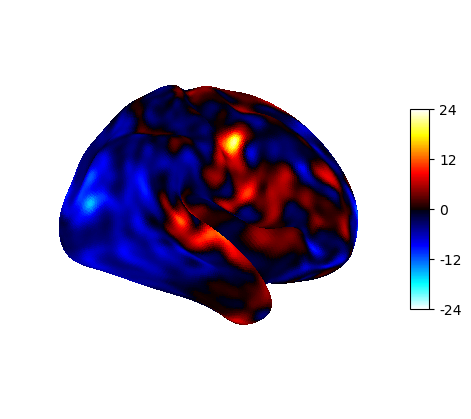

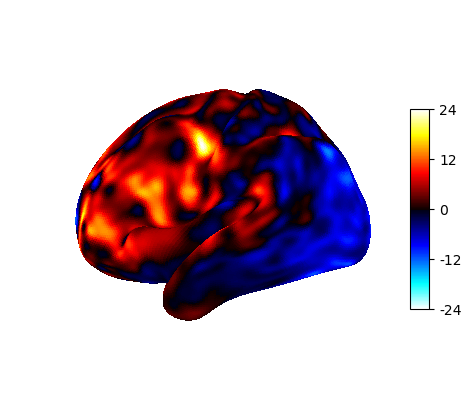

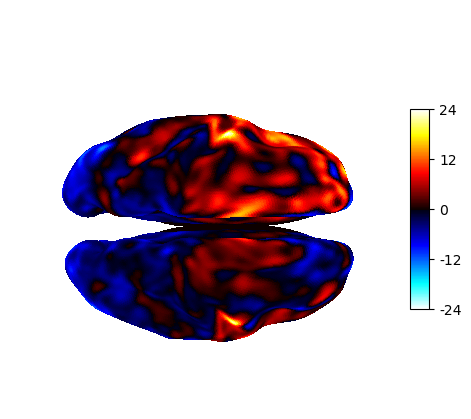

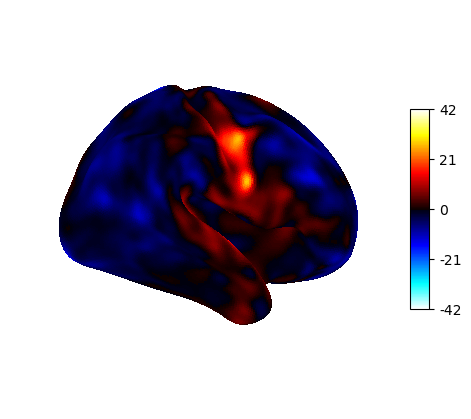

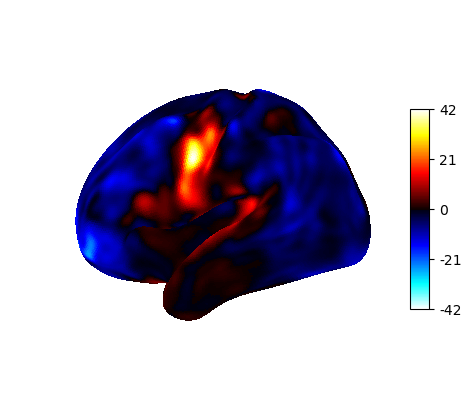

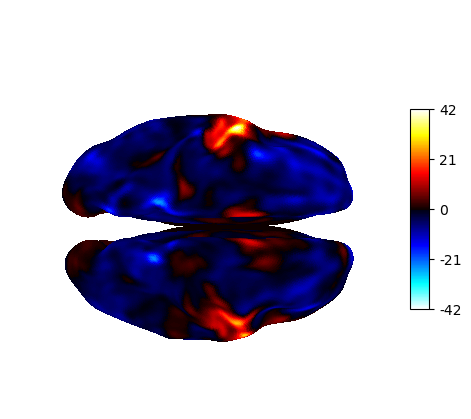

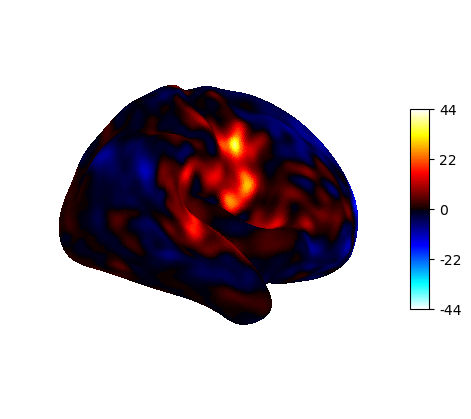

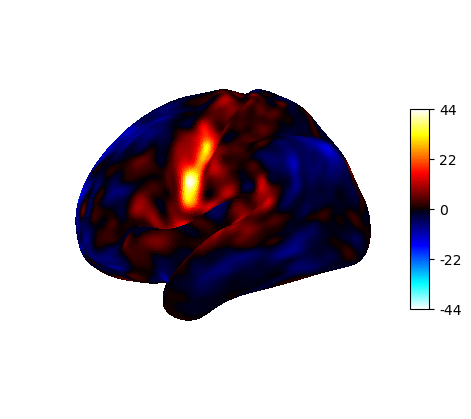

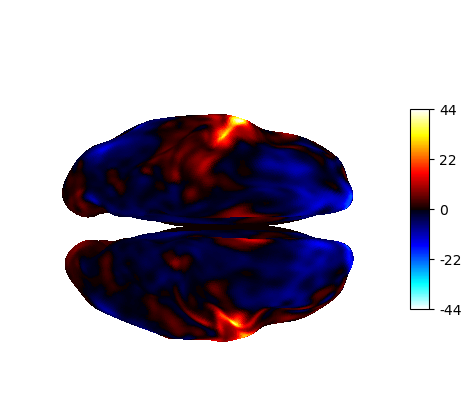

In [72]:
for sm in sample_mdd:
    nplot.plot_surf_stat_map(
            hcp.mesh.inflated, hcp.cortex_data(mdd[sm].to_numpy()), hemi='right',# threshold=fdr[sc],
            colorbar=True,
            bg_map=hcp.mesh.sulc)

    nplot.plot_surf_stat_map(
            hcp.mesh.inflated, hcp.cortex_data(mdd[sm].to_numpy()), hemi='left', #threshold=fdr[sc],
            colorbar=True,
            bg_map=hcp.mesh.sulc)

    nplot.plot_surf_stat_map(
            hcp.mesh.inflated, hcp.cortex_data(mdd[sm].to_numpy()), view='dorsal', #threshold=fdr[sc],
            colorbar=True,
            bg_map=hcp.mesh.sulc)

    plt.show()